# Traditional Methods for ML on Graphs

### Install GraKeL library

In [77]:
try:
    # Check if installed:
    import grakel
except ImportError:
    # If not , install it.
    %pip install grakel==0.1.8

### Import necessary libraries

In [78]:
import itertools
import random
import time
from collections import defaultdict
from typing import Callable, Dict, List, Optional, Tuple, Union

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [79]:
def seed_everything(seed: Optional[int] = None) -> None:
    random.seed(seed)
    np.random.seed(seed)


seed_everything(42)

### Constructing a graph from edge list

In [80]:
edge_list = [("A", "C"), ("B", "C"), ("B", "D"), ("C", "D")]
G = nx.Graph(edge_list)


In [81]:
def features_example(
    feature_extraction_fun: Callable[[nx.Graph], Dict[Union[str, Tuple[str, str]], Union[int, float]]],
    fig_size: Tuple[int, int] = (6, 3),
    node_color: str = "tab:orange",
    node_size: int = 1000,
    width: int = 2,
    seed: Optional[int] = None,) -> None:
    
    
    
    name = feature_extraction_fun.__name__.replace("_", " ").capitalize()
    features = feature_extraction_fun(G)
    pos = nx.spring_layout(G, seed=seed)

    plt.figure(figsize=fig_size)
    nx.draw(G, pos=pos, node_color=node_color, node_size=node_size, width=width, with_labels=True)
    plt.show()

    print(f"\n{name} values:")
    for key, value in sorted(features.items(), key=lambda item: item[0]):
        print(f"- {key}: {value:.2f}")

# Node Features: Node Degree

In [82]:
def node_degree(G: nx.Graph) -> Dict[str, int]:
    return dict(G.degree)

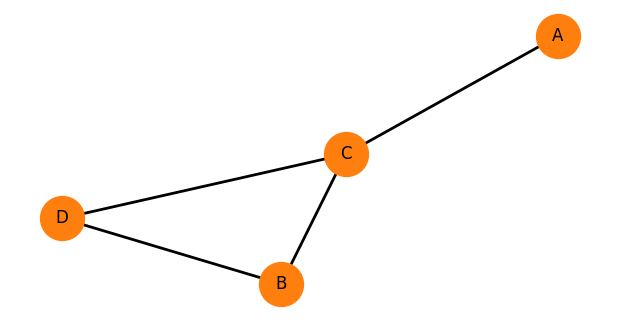


Node degree values:
- A: 1.00
- B: 2.00
- C: 3.00
- D: 2.00


In [83]:
features_example(node_degree, seed=42)

# Node Centrality (1)

## Eigenvector centrality

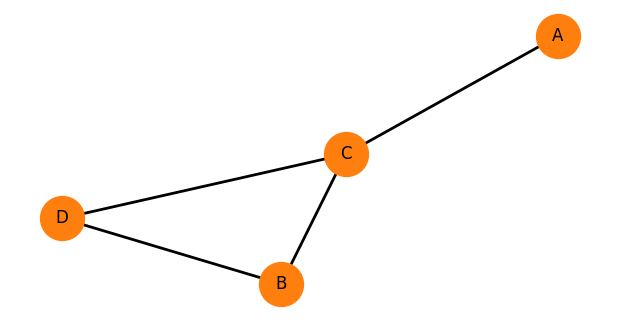


Eigenvector centrality values:
- A: 0.28
- B: 0.52
- C: 0.61
- D: 0.52


In [84]:
features_example(nx.eigenvector_centrality, seed=42)

# Node Centrality (2)

## Betweenness centrality

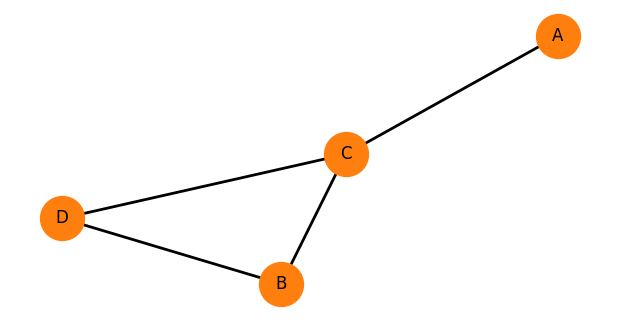


Betweenness centrality values:
- A: 0.00
- B: 0.00
- C: 0.67
- D: 0.00


In [85]:
features_example(nx.betweenness_centrality, seed=42)

# Node Centrality (3)

## Closeness centrality

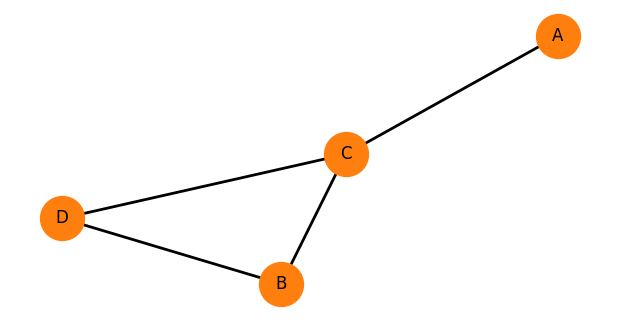


Closeness centrality values:
- A: 0.60
- B: 0.75
- C: 1.00
- D: 0.75


In [86]:
features_example(nx.closeness_centrality, seed=42)

# Node Features: Clustering Coefficient

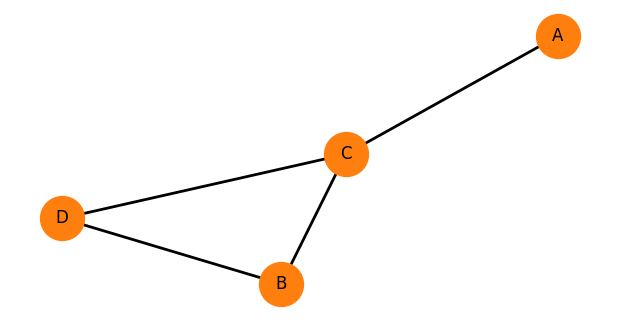


Clustering values:
- A: 0.00
- B: 1.00
- C: 0.33
- D: 1.00


In [87]:
features_example(nx.clustering, seed=42)

# Link-Level Features: Overview

# Distance-Based Features

## Shortest-path distance between two nodes

In [88]:
def shortest_path_length(G: nx.Graph) -> Dict[Tuple[str, str], int]:
    out = {}
    for node_pair in itertools.combinations(G.nodes, 2):
        out[node_pair] = nx.shortest_path_length(G, *node_pair)

    return out

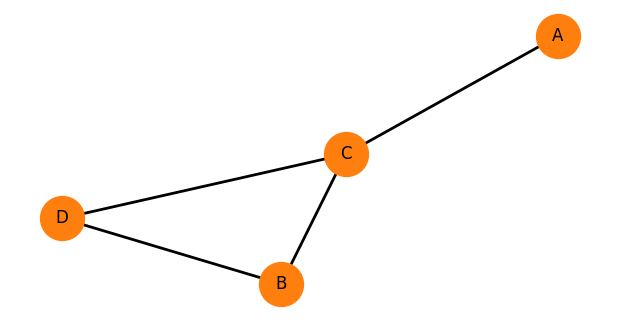


Shortest path length values:
- ('A', 'B'): 2.00
- ('A', 'C'): 1.00
- ('A', 'D'): 2.00
- ('B', 'D'): 1.00
- ('C', 'B'): 1.00
- ('C', 'D'): 1.00


In [89]:
features_example(shortest_path_length, seed=42)

# Local Neighborhood Overlap

## Common neighbors

In [90]:
def num_common_neighbors(G: nx.Graph) -> Dict[Tuple[str, str], int]:
    return {edge: len(list((nx.common_neighbors(G, *edge)))) for edge in itertools.combinations(G.nodes, 2)}

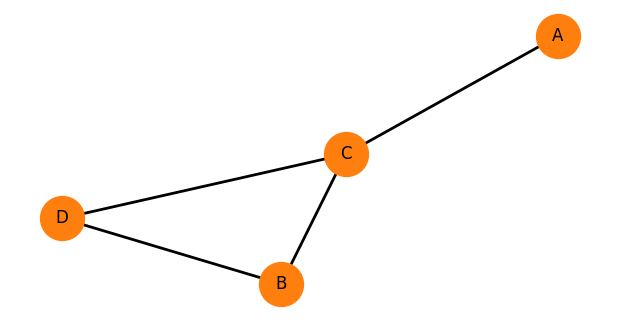


Num common neighbors values:
- ('A', 'B'): 1.00
- ('A', 'C'): 0.00
- ('A', 'D'): 1.00
- ('B', 'D'): 1.00
- ('C', 'B'): 1.00
- ('C', 'D'): 1.00


In [91]:
features_example(num_common_neighbors, seed=42)

## Jaccard's coefficient

In [92]:
def jaccard_coefficient(G: nx.Graph) -> Dict[Tuple[str, str], float]:
    out = {}
    for item in nx.jaccard_coefficient(G, itertools.combinations(G.nodes, 2)):
        out[(item[:2])] = item[2]

    return out

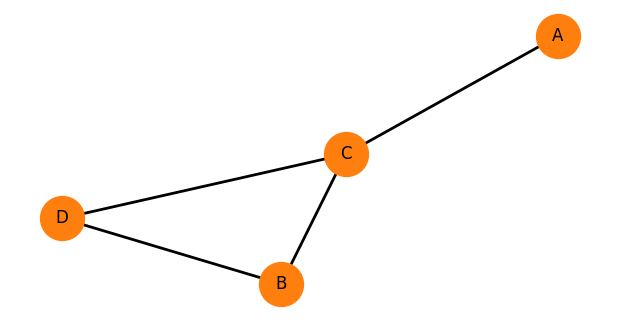


Jaccard coefficient values:
- ('A', 'B'): 0.50
- ('A', 'C'): 0.00
- ('A', 'D'): 0.50
- ('B', 'D'): 0.33
- ('C', 'B'): 0.25
- ('C', 'D'): 0.25


In [93]:
features_example(jaccard_coefficient, seed=42)

## Adamic-Adar index

In [94]:
def adamic_adar_index(G: nx.Graph) -> Dict[Tuple[str, str], float]:
    out = {}
    for item in nx.adamic_adar_index(G, itertools.combinations(G.nodes, 2)):
        out[(item[:2])] = item[2]

    return out

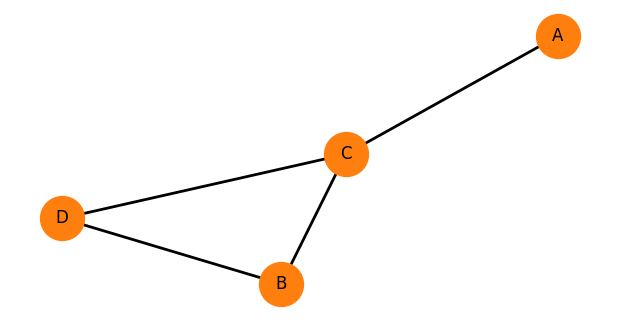


Adamic adar index values:
- ('A', 'B'): 0.91
- ('A', 'C'): 0.00
- ('A', 'D'): 0.91
- ('B', 'D'): 0.91
- ('C', 'B'): 1.44
- ('C', 'D'): 1.44


In [95]:
features_example(adamic_adar_index, seed=42)

# Global Neighborhood Overlap

In [96]:
def get_katz_index_matrix(G: nx.Graph, beta: float) -> np.ndarray:
    A = nx.adjacency_matrix(G).todense()
    X = beta * A
    max_eigval = np.linalg.eigvals(X).max()
    if max_eigval >= 1.0:
        raise ValueError(
            "to apply the geometric series of matrices, the maximum eigenvalue of beta * A must be < 1, got "
            f"{max_eigval}"
        )

    I = np.eye(X.shape[0])
    S = np.linalg.inv(I - X) - I
    return S


def katz_index_beta_03(G: nx.Graph) -> Dict[Tuple[str, str], float]:
    S = get_katz_index_matrix(G, 0.3)
    nodes = list(G.nodes)
    ki = {}
    for node_pair in itertools.combinations(G.nodes, 2):
        row_idx = nodes.index(node_pair[0])
        col_idx = nodes.index(node_pair[1])
        ki[node_pair] = S[row_idx, col_idx]

    return ki


katz_index_beta_03.__name__ = "katz_index_(beta=0.3)"

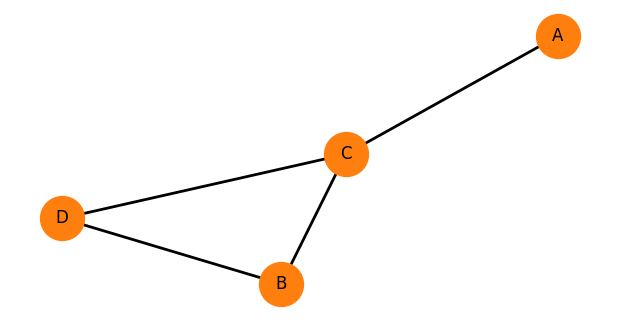


Katz index (beta=0.3) values:
- ('A', 'B'): 0.20
- ('A', 'C'): 0.46
- ('A', 'D'): 0.20
- ('B', 'D'): 0.61
- ('C', 'B'): 0.66
- ('C', 'D'): 0.66


In [97]:
features_example(katz_index_beta_03, seed=42)

# Graph-Level Features: Overview

#### From Images to Graphs:

We will now transform the digits into graphs and perform graph classification. 

We will transform each image into a square grid graph. Each pixel corresponds to a node. 

Two nodes are connected by an edge if they are direct neighbors. For instance, pixel (0,0) is connected to pixel (1,0) and to pixel (0,1). 

Note also that the node attributes (i.e., pixel intensities) are transformed into discrete labels, and that the edges are also assigned dicrete labels (i.e., labels 1 and 2 for the horizontal and vertical edges, respectively).

In [154]:
import grakel
from grakel.kernels import GraphletSampling, WeisfeilerLehman
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

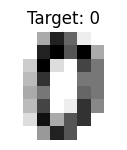

In [160]:
digits = load_digits()
images = digits.images
y = digits.target

for i in range(1):
    plt.subplot(1, 4, i + 1)
    plt.imshow(images[i], cmap=plt.cm.gray_r, interpolation="nearest")
    plt.title(f"Target: {y[i]}")
    plt.axis("off")

In [161]:
def images_to_graphs(images: np.ndarray) -> List[grakel.Graph]:
    num_images, height, width = images.shape
    
    graphs = []
    edges = []
    edge_labels = {}
    for row_idx in range(height):
        for col_idx in range(width):
            if col_idx < width - 1:
                edge = (row_idx * height + col_idx, row_idx * height + col_idx + 1)
                edges.append(edge)
                edge_labels[edge] = 1

            if row_idx < height - 1:
                edge = (row_idx * height + col_idx, (row_idx + 1) * height + col_idx)
            
                edges.append(edge)
                edge_labels[edge] = 2
    G = nx.Graph(edges)
    nx.draw_networkx(G)

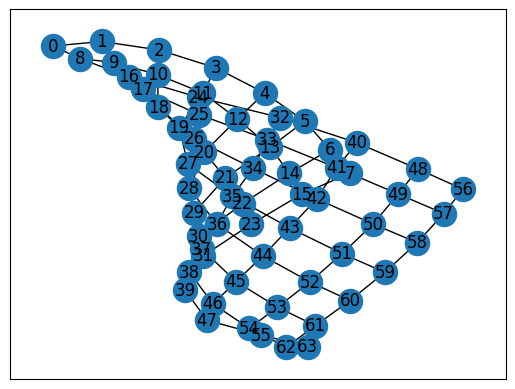

In [162]:
images_to_graphs(images)